<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Study-Design" data-toc-modified-id="Study-Design-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Study Design</a></span><ul class="toc-item"><li><span><a href="#Data" data-toc-modified-id="Data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Collect-Model-Functions" data-toc-modified-id="Collect-Model-Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Collect Model Functions</a></span><ul class="toc-item"><li><span><a href="#Gaussian-Mixture" data-toc-modified-id="Gaussian-Mixture-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Gaussian Mixture</a></span></li><li><span><a href="#Garch" data-toc-modified-id="Garch-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Garch</a></span></li><li><span><a href="#Gaussian-KDE" data-toc-modified-id="Gaussian-KDE-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Gaussian KDE</a></span></li><li><span><a href="#Historical" data-toc-modified-id="Historical-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Historical</a></span></li></ul></li></ul></li><li><span><a href="#Run-VAR-model" data-toc-modified-id="Run-VAR-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Run VAR model</a></span></li><li><span><a href="#Evaluate-MAPE-results" data-toc-modified-id="Evaluate-MAPE-results-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Evaluate MAPE results</a></span><ul class="toc-item"><li><span><a href="#Test-model-for-other-symbols" data-toc-modified-id="Test-model-for-other-symbols-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Test model for other symbols</a></span></li></ul></li><li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Conclusions</a></span></li><li><span><a href="#Resources-and-Citations" data-toc-modified-id="Resources-and-Citations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Resources and Citations</a></span></li></ul></div>

In [1]:
%load_ext watermark
%watermark

%load_ext autoreload
%autoreload 2

from IPython.display import display

# import standard libs
from pathlib import Path
import sys
import time
import os
from copy import copy

# get project dir
def local_get_relative_project_dir(project_repo_name=None, partial=True):
    """helper fn to get local project directory"""
    current_working_directory = Path.cwd()
    cwd_parts = current_working_directory.parts
    if partial:
        while project_repo_name not in cwd_parts[-1]:
            current_working_directory = current_working_directory.parent
            cwd_parts = current_working_directory.parts
    else:
        while cwd_parts[-1] != project_repo_name:
            current_working_directory = current_working_directory.parent
            cwd_parts = current_working_directory.parts
    return current_working_directory


PROJECT_REPO_NAME = "mixture_model_trading_public"
project_dir = local_get_relative_project_dir(PROJECT_REPO_NAME)
data_dir = project_dir / "data"
script_dir = project_dir / "scripts"
sys.path.append(script_dir.as_posix())

# import python scientific stack
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import pandas_datareader as pdr
import numpy as np
import sklearn.mixture as mix
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as stats
from arch import arch_model
from numba import jit
import math

# import visual tools
from mpl_toolkits import mplot3d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
import plotnine as pn
import mizani.breaks as mzb
import mizani.formatters as mzf
import seaborn as sns
savefig_kwds=dict(dpi=300, bbox_inches='tight')

# import util libs
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from utils import cprint

# set globals
blue, gold, green, red, purple, brown = sns.color_palette('colorblind', 6)
RANDOM_STATE = 777

print()
%watermark -p pandas,pandas_datareader,numpy,sklearn,statsmodels,scipy,matplotlib,seaborn,plotnine

2019-11-01T15:51:00-06:00

CPython 3.7.5
IPython 7.9.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-54-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit

pandas 0.25.2
pandas_datareader 0.8.0
numpy 1.17.2
sklearn 0.21.3
statsmodels 0.10.1
scipy 1.3.1
matplotlib 3.1.1
seaborn 0.9.0
plotnine 0.6.0


In [2]:
sns_params = {
    "axes.grid": True,
    "ytick.left": True,
    "xtick.bottom": True,
    "xtick.major.size": 2,
    "ytick.major.size": 2,
    "font.size": 11,
    "font.weight": "medium",
    "figure.figsize": (10, 7),
    "font.family": "DejaVu Sans Mono",  # "Ubuntu Mono",
}

sns.set(context="poster", style="ticks", rc=sns_params)
savefig_kwds = dict(dpi=90, bbox_inches="tight", frameon=True, format="png")
flatui = ["#3498db", "#9b59b6", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "#f4cae4"]
sns.set_palette(sns.color_palette(flatui, 7))

## Study Design

1. choose symbol to test (stats.guassian_kde and garch are only univariate)
2. collect model functions
3. decide on frequency and sample splits
4. iterate over train, test data 
    - collect forecasts
    - compute results for forecast period
    - collect results for forecast period
5. aggregate results
6. evaluate results and plots

### Data

In [3]:
infp = Path(data_dir/'tiingo_etf_returns_ending_2017-12-31.parq')
R = pd.read_parquet(infp)
cprint(R)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
               SPY     QQQ     TLT    GLD     EFA     EEM
date                                                     
2017-12-22 -0.0003 -0.0011  0.0014 0.0052  0.0026  0.0084
2017-12-26 -0.0012 -0.0054  0.0030 0.0068 -0.0003 -0.0009
2017-12-27  0.0005  0.0001  0.0129 0.0038  0.0019  0.0026
2017-12-28  0.0021  0.0012 -0.0009 0.0051  0.0006  0.0068
2017-12-29 -0.0038 -0.0062  0.0016 0.0065  0.0007  0.0047
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3301 entries, 2004-11-19 to 2017-12-29
Data columns (total 6 columns):
SPY    3301 non-null float64
QQQ    3301 non-null float64
TLT    3301 non-null float64
GLD    3301 non-null float64
EFA    3301 non-null float64
EEM    3301 non-null float64
dtypes: float64(6)
memory usage: 180.5 KB
None
----------------

In [4]:
test_symbol = 'SPY'
data = R[test_symbol].to_frame().loc['2005':].copy()
cprint(data)

-------------------------------------------------------------------------------
dataframe information
-------------------------------------------------------------------------------
               SPY
date              
2017-12-22 -0.0003
2017-12-26 -0.0012
2017-12-27  0.0005
2017-12-28  0.0021
2017-12-29 -0.0038
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3272 entries, 2005-01-03 to 2017-12-29
Data columns (total 1 columns):
SPY    3272 non-null float64
dtypes: float64(1)
memory usage: 51.1 KB
None
-------------------------------------------------------------------------------



### Collect Model Functions

In [5]:
def calc_quantile_var(data, alpha=0.05):
    """
    compute var by quantile
    """
    return data.quantile(alpha)

#### Gaussian Mixture

In [6]:
# gaussian mixture model, 2 components

def gmm(data, n_components, max_iter=150, random_state=0, **kwds):
    """
    gaussian mixture model by sklearn
    """
    model = mix.GaussianMixture(n_components, max_iter=max_iter,
                                random_state=random_state, **kwds)
    model.fit(data)
    return model

In [7]:
def gmm_sample(data, n_components=2, max_iter=150, random_state=0,
                     n_samples=1000, risky=True, **kwds):
    """
    sample from the risky component
    """
    model = gmm(data, n_components=n_components,
                max_iter=max_iter, random_state=random_state, **kwds)
    X_s, y_s = model.sample(n_samples)
    df = pd.DataFrame(X_s, columns=data.columns).assign(component=y_s)
    if not risky: 
        ser = pd.Series(X_s.ravel())
        ser.name = 'gmm'
        return ser
    
    risky = df.groupby('component').mean().mean(1).argmin()
    ser = df.query('component==@risky').set_index('component').squeeze()
    ser.name = 'gmm_risky'
    return ser
    

In [8]:
def calc_gmm_var(data, n_components=2, max_iter=150, random_state=0, 
                 n_samples=1000, risky=True, **kwds):
    """
    compute quantile var for gmm risky component
    """
    gmm_samples = gmm_sample(data, 2, risky=risky)
    return calc_quantile_var(gmm_samples)

gmm_var = calc_gmm_var(data, risky=False)
gmm_var

-0.01796428573783222

#### Garch

In [9]:
# garch model 1,0,1
def garch(data, p=1, o=0, q=1, update_freq=5, **kwds):
    model = arch_model(data, 'Garch', p=p, o=o, q=q, **kwds)
    res = model.fit(update_freq=update_freq, disp=False)
    return res

def garch_forecast_sim(data, p=1, o=0, q=1, update_freq=5,
                       horizon=30, n_simulations=1000, **kwds):
    np.random.seed(0)
    garch_model = garch(data,p=p,o=o,q=q,update_freq=update_freq) 
    forecasts = garch_model.forecast(
        horizon=horizon, method='simulation',simulations=n_simulations)
    sim_ser = pd.Series(forecasts.simulations.values[-1,:,-1])
    sim_ser.name = 'garch'    
    return sim_ser

def calc_garch_var(data, p=1, o=0, q=1, update_freq=5, horizon=30, n_simulations=1000, alpha=0.05, **kwds):
    sim_ser = garch_forecast_sim(data, p=p, o=o, q=q, update_freq=update_freq,
                                 horizon=horizon, n_simulations=n_simulations//horizon, **kwds)
    var = calc_quantile_var(sim_ser, alpha=alpha)
    return var

calc_garch_var(data, n_simulations=10000)

Iteration:      5,   Func. Count:     67,   Neg. LLF: -8197.75619100534
Iteration:     10,   Func. Count:    144,   Neg. LLF: -2425.966037319834


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


-0.07974787795934174

In [10]:
calc_garch_var(data, n_simulations=10000, dist='studentT')

Iteration:      5,   Func. Count:     67,   Neg. LLF: -8197.75619100534
Iteration:     10,   Func. Count:    144,   Neg. LLF: -2425.966037319834


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


-0.08237194644880586

#### Gaussian KDE

In [11]:
# guassian kde
def gkde(data, **kwds):
    if isinstance(data, pd.DataFrame): data=data.squeeze()
    return stats.gaussian_kde(data, **kwds)

def sample_gaussian_kde(data, n_samples=1000, **kwds):
    np.random.seed(0)
    model = gkde(data, **kwds)
    samples = model.resample(n_samples).ravel()
    ser = pd.Series(samples)
    ser.name = 'gaussian_kde'
    return ser

def calc_gaussian_kde_var(data, n_samples=1000, alpha=0.05, **kwds):
    samples = sample_gaussian_kde(data, n_samples=n_samples, **kwds)
    return calc_quantile_var(samples, alpha=alpha)

calc_gaussian_kde_var(data)

-0.021823126146631528

#### Historical 

In [12]:
# historical var

def calc_historical_var(data, alpha=0.05): 
    if isinstance(data, pd.DataFrame): data=data.squeeze()
    return calc_quantile_var(data, alpha=alpha)

calc_historical_var(data)

-0.017334040349494213

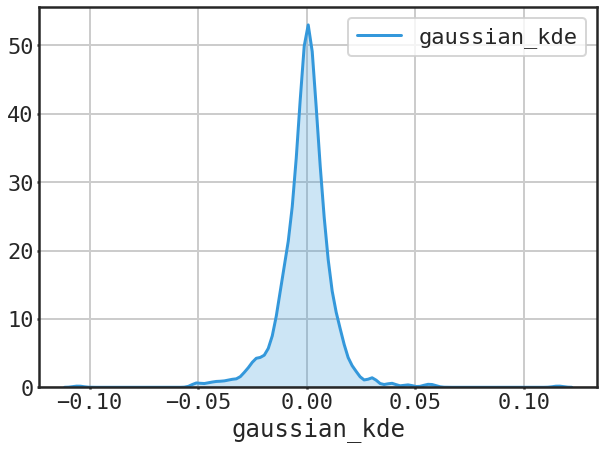

In [13]:
def plot_hist_samples(samples, ax=None):
    if not ax: ax = plt.gca()
    
    sns.distplot(samples, ax=ax, label=samples.name, 
                 hist=False, kde_kws={'shade':True})
    ax.legend()
    
plot_hist_samples(sample_gaussian_kde(data))    

Iteration:      5,   Func. Count:     67,   Neg. LLF: -8197.75619100534
Iteration:     10,   Func. Count:    144,   Neg. LLF: -2425.966037319834


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


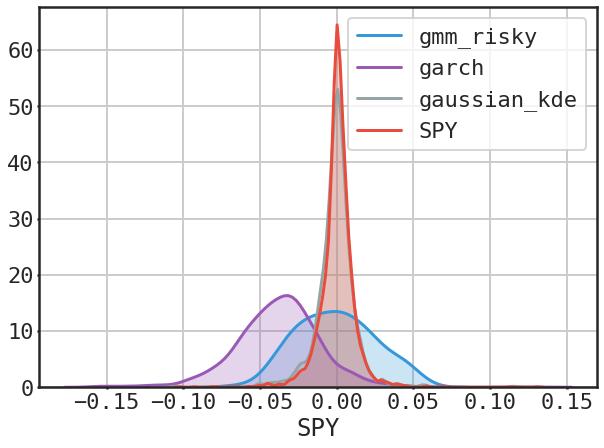

In [14]:
gmm_samples = gmm_sample(data, 2)
garch_samples = garch_forecast_sim(data)
g_kde_samples = sample_gaussian_kde(data)
hist_data = data.squeeze()

sample_series = [gmm_samples, garch_samples, g_kde_samples, hist_data]
f, ax = plt.subplots(figsize=(10,7))
for s in sample_series:
    plot_hist_samples(s, ax=ax)

## Run VAR model

In [15]:
month_index = data.resample('M').mean().index
month_index

DatetimeIndex(['2005-01-31', '2005-02-28', '2005-03-31', '2005-04-30',
               '2005-05-31', '2005-06-30', '2005-07-31', '2005-08-31',
               '2005-09-30', '2005-10-31',
               ...
               '2017-03-31', '2017-04-30', '2017-05-31', '2017-06-30',
               '2017-07-31', '2017-08-31', '2017-09-30', '2017-10-31',
               '2017-11-30', '2017-12-31'],
              dtype='datetime64[ns]', name='date', length=156, freq='M')

In [16]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

np.random.seed(0)

lookback = 252

# stash model predictions
keys = ['gmm', 'gmm_risky', 'garch_normal', 'garch_t', 'gkde', 'historical']
predictions = dict.fromkeys(keys)

for k in predictions.keys(): predictions[k] = []

# stash actual minimum returns for next period
min_month_returns = []

### begin model code ###

for i, month_end in enumerate(month_index):
    if not data.loc[:month_end].shape[0] > lookback: continue
    
    train = data.loc[:month_end].iloc[-lookback:]
    test = data.loc[month_end+pd.Timedelta(days=1):month_index[i+1]]
    
    # calc vars
    gmm_var = calc_gmm_var(train, risky=False)
    gmm_risky_var = calc_gmm_var(train, risky=True)
    garch_norm_var = calc_garch_var(train, n_simulations=10000, dist='Normal')
    garch_t_var = calc_garch_var(train, n_simulations=10000, dist='StudentT')
    gkde_var = calc_gaussian_kde_var(train)
    hist_var = calc_historical_var(train)    
    
    train_vars = [gmm_var, gmm_risky_var,
                  garch_norm_var, garch_t_var,
                  gkde_var, hist_var]
    for k, var in zip(predictions.keys(), train_vars): predictions[k].append(var)
        
    min_month_returns.append(test.squeeze().min())
    

/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8

Iteration:      5,   Func. Count:     52,   Neg. LLF: -914.1458613565688
Iteration:      5,   Func. Count:     52,   Neg. LLF: -914.1458613565688


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8

Iteration:      5,   Func. Count:     59,   Neg. LLF: -922.0173358859662
Iteration:      5,   Func. Count:     59,   Neg. LLF: -922.0173358859662
Iteration:      5,   Func. Count:     51,   Neg. LLF: -907.682660907031
Iteration:      5,   Func. Count:     51,   Neg. LLF: -907.682660907031


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -899.3005489074808
Iteration:      5,   Func. Count:     55,   Neg. LLF: -899.3005489074808


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8

Iteration:      5,   Func. Count:     64,   Neg. LLF: -936.9202516164103
Iteration:      5,   Func. Count:     64,   Neg. LLF: -936.9202516164103


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8

Iteration:      5,   Func. Count:     55,   Neg. LLF: -913.4880557705164
Iteration:      5,   Func. Count:     55,   Neg. LLF: -913.4880557705164


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8

Iteration:      5,   Func. Count:     59,   Neg. LLF: -833.1182054859316
Iteration:     10,   Func. Count:    133,   Neg. LLF: -833.1198053195521
Iteration:      5,   Func. Count:     59,   Neg. LLF: -833.1182054859316
Iteration:     10,   Func. Count:    133,   Neg. LLF: -833.1198053195521
Iteration:      5,   Func. Count:     55,   Neg. LLF: -814.6396201650816
Iteration:     10,   Func. Count:    104,   Neg. LLF: -815.4197550173155
Iteration:     15,   Func. Count:    140,   Neg. LLF: -815.9207961229683
Iteration:      5,   Func. Count:     55,   Neg. LLF: -814.6396201650816
Iteration:     10,   Func. Count:    104,   Neg. LLF: -815.4197550173155
Iteration:     15,   Func. Count:    140,   Neg. LLF: -815.9207961229683


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     57,   Neg. LLF: -793.3707660653877
Iteration:     10,   Func. Count:    118,   Neg. LLF: -793.3744432450856
Iteration:      5,   Func. Count:     57,   Neg. LLF: -793.3707660653877
Iteration:     10,   Func. Count:    118,   Neg. LLF: -793.3744432450856


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     44,   Neg. LLF: -758.2367885314447
Iteration:      5,   Func. Count:     44,   Neg. LLF: -758.2367885314447
Iteration:      5,   Func. Count:     51,   Neg. LLF: -750.8978127813756
Iteration:     10,   Func. Count:     89,   Neg. LLF: -750.9818174265409
Iteration:      5,   Func. Count:     51,   Neg. LLF: -750.8978127813756
Iteration:     10,   Func. Count:     89,   Neg. LLF: -750.9818174265409


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8

Iteration:      5,   Func. Count:     48,   Neg. LLF: -749.7379237573191
Iteration:     10,   Func. Count:     93,   Neg. LLF: -749.8232139386756
Iteration:      5,   Func. Count:     48,   Neg. LLF: -749.7379237573191
Iteration:     10,   Func. Count:     93,   Neg. LLF: -749.8232139386756
Iteration:      5,   Func. Count:     56,   Neg. LLF: -676.1545003678439
Iteration:      5,   Func. Count:     56,   Neg. LLF: -676.1545003678439


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8

Iteration:      5,   Func. Count:     54,   Neg. LLF: -627.9949374612164
Iteration:     10,   Func. Count:     88,   Neg. LLF: -629.6030825749457
Iteration:      5,   Func. Count:     54,   Neg. LLF: -627.9949374612164
Iteration:     10,   Func. Count:     88,   Neg. LLF: -629.6030825749457


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8

Iteration:      5,   Func. Count:     53,   Neg. LLF: -790.2437002479801
Iteration:     10,   Func. Count:     95,   Neg. LLF: -790.7478068322041
Iteration:      5,   Func. Count:     53,   Neg. LLF: -790.2437002479801
Iteration:     10,   Func. Count:     95,   Neg. LLF: -790.7478068322041
Iteration:      5,   Func. Count:     57,   Neg. LLF: -778.9314561682039
Iteration:      5,   Func. Count:     57,   Neg. LLF: -778.9314561682039


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -804.5536359656487
Iteration:      5,   Func. Count:     55,   Neg. LLF: -804.5536359656487
Iteration:      5,   Func. Count:     63,   Neg. LLF: -811.8340461730465
Iteration:      5,   Func. Count:     63,   Neg. LLF: -811.8340461730465


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8

Iteration:      5,   Func. Count:     54,   Neg. LLF: -840.8495943156241
Iteration:     10,   Func. Count:    115,   Neg. LLF: -840.8505242046907
Iteration:      5,   Func. Count:     54,   Neg. LLF: -840.8495943156241
Iteration:     10,   Func. Count:    115,   Neg. LLF: -840.8505242046907


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8

Iteration:      5,   Func. Count:     55,   Neg. LLF: -767.0054763718581
Iteration:     10,   Func. Count:    118,   Neg. LLF: -767.006661590753
Iteration:      5,   Func. Count:     55,   Neg. LLF: -767.0054763718581
Iteration:     10,   Func. Count:    118,   Neg. LLF: -767.006661590753
Iteration:      5,   Func. Count:     62,   Neg. LLF: -755.472454278616
Iteration:      5,   Func. Count:     62,   Neg. LLF: -755.472454278616


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8

Iteration:      5,   Func. Count:     58,   Neg. LLF: -830.9413023485208
Iteration:      5,   Func. Count:     58,   Neg. LLF: -830.9413023485208
Iteration:      5,   Func. Count:     55,   Neg. LLF: -861.8987157985571


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8

Iteration:      5,   Func. Count:     55,   Neg. LLF: -861.8987157985571


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8

Iteration:      5,   Func. Count:     55,   Neg. LLF: -887.187628687253
Iteration:      5,   Func. Count:     55,   Neg. LLF: -887.187628687253
Iteration:      5,   Func. Count:     50,   Neg. LLF: -881.9928617631385
Iteration:      5,   Func. Count:     50,   Neg. LLF: -881.9928617631385


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     51,   Neg. LLF: -887.8007077393802
Iteration:     10,   Func. Count:    100,   Neg. LLF: -887.8614579638557
Iteration:      5,   Func. Count:     51,   Neg. LLF: -887.8007077393802
Iteration:     10,   Func. Count:    100,   Neg. LLF: -887.8614579638557


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8

Iteration:      5,   Func. Count:     54,   Neg. LLF: -901.665021904638
Iteration:      5,   Func. Count:     54,   Neg. LLF: -901.665021904638
Iteration:      5,   Func. Count:     55,   Neg. LLF: -892.6705770467918


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -892.6705770467918
Iteration:      5,   Func. Count:     53,   Neg. LLF: -889.9512405746682


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     53,   Neg. LLF: -889.9512405746682
Iteration:      5,   Func. Count:     55,   Neg. LLF: -896.7984148524836
Iteration:      5,   Func. Count:     55,   Neg. LLF: -896.7984148524836


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     44,   Neg. LLF: -913.1477905709668
Iteration:     10,   Func. Count:     80,   Neg. LLF: -913.248294888178
Iteration:      5,   Func. Count:     44,   Neg. LLF: -913.1477905709668
Iteration:     10,   Func. Count:     80,   Neg. LLF: -913.248294888178


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -908.3813038862212
Iteration:      5,   Func. Count:     55,   Neg. LLF: -908.3813038862212
Iteration:      5,   Func. Count:     58,   Neg. LLF: -915.4626298700796
Iteration:      5,   Func. Count:     58,   Neg. LLF: -915.4626298700796


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     44,   Neg. LLF: -900.5025650035719
Iteration:      5,   Func. Count:     44,   Neg. LLF: -900.5025650035719
Iteration:      5,   Func. Count:     55,   Neg. LLF: -896.9079768816874
Iteration:      5,   Func. Count:     55,   Neg. LLF: -896.9079768816874
Iteration:      5,   Func. Count:     55,   Neg. LLF: -899.6649557570923
Iteration:      5,   Func. Count:     55,   Neg. LLF: -899.6649557570923
Iteration:      5,   Func. Count:     54,   Neg. LLF: -860.6361331978118
Iteration:     10,   Func. Count:     98,   Neg. LLF: -861.060819097447
Iteration:     15,   Func. Count:    130,   Neg. LLF: -861.3154751756184
Iteration:      5,   Func. Count:     54,   Neg. LLF: -860.6361331978118
Iteration:     10,   Func. Count:     98,   Neg. LLF: -861.060819097447
Iteration:     15,   Func. Count:    130,   Neg. LLF: -861.3154751756184


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     51,   Neg. LLF: -836.7047813939882
Iteration:     10,   Func. Count:     88,   Neg. LLF: -837.2552688364929
Iteration:      5,   Func. Count:     51,   Neg. LLF: -836.7047813939882
Iteration:     10,   Func. Count:     88,   Neg. LLF: -837.2552688364929
Iteration:      5,   Func. Count:     54,   Neg. LLF: -832.0911351396369
Iteration:      5,   Func. Count:     54,   Neg. LLF: -832.0911351396369
Iteration:      5,   Func. Count:     44,   Neg. LLF: -823.0158427169991
Iteration:      5,   Func. Count:     44,   Neg. LLF: -823.0158427169991
Iteration:      5,   Func. Count:     56,   Neg. LLF: -811.14423615947
Iteration:      5,   Func. Count:     56,   Neg. LLF: -811.14423615947


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8

Iteration:      5,   Func. Count:     54,   Neg. LLF: -812.5705707796897
Iteration:     10,   Func. Count:    102,   Neg. LLF: -812.8618713209967
Iteration:     15,   Func. Count:    136,   Neg. LLF: -812.9931799942157
Iteration:      5,   Func. Count:     54,   Neg. LLF: -812.5705707796897
Iteration:     10,   Func. Count:    102,   Neg. LLF: -812.8618713209967
Iteration:     15,   Func. Count:    136,   Neg. LLF: -812.9931799942157
Iteration:      5,   Func. Count:     50,   Neg. LLF: -805.8690637031837
Iteration:      5,   Func. Count:     50,   Neg. LLF: -805.8690637031837
Iteration:      5,   Func. Count:     52,   Neg. LLF: -809.679026790252
Iteration:      5,   Func. Count:     52,   Neg. LLF: -809.679026790252


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


Iteration:      5,   Func. Count:     55,   Neg. LLF: -845.1940130112805
Iteration:      5,   Func. Count:     55,   Neg. LLF: -845.1940130112805


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8

Iteration:      5,   Func. Count:     55,   Neg. LLF: -859.9070218073718
Iteration:      5,   Func. Count:     55,   Neg. LLF: -859.9070218073718
Iteration:      5,   Func. Count:     46,   Neg. LLF: -877.5884636173316
Iteration:      5,   Func. Count:     46,   Neg. LLF: -877.5884636173316


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8

Iteration:      5,   Func. Count:     59,   Neg. LLF: -971.1521388459545
Iteration:      5,   Func. Count:     59,   Neg. LLF: -971.1521388459545


/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/media/kingmaster/HDD/anaconda3/envs/py37/lib/python3.7/site-packages/arch/univariate/base.py:605: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


IndexError: index 156 is out of bounds for axis 0 with size 156

## Evaluate MAPE results

In this experiment we will use [Mean Absolute Percentage Error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) to evaluate the VAR prediction results. This is a relatively easy to interpret measure of the prediction error.

In [ ]:
# https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python/42251083#42251083

def mape_vectorized_v2(actual, predict): 
    mask = actual != 0
    return (np.fabs(actual - predict)/actual)[mask].mean() 

model_errors = dict.fromkeys(keys)
for k in model_errors.keys(): model_errors[k] = []
    
actual = np.asarray(min_month_returns)
for k, predict in predictions.items():
    model_errors[k].append(mape_vectorized_v2(actual, predict))

error_df = (pd.DataFrame.
            from_dict(model_errors)
            .T
            .squeeze()
            .sort_values(ascending=False)*100.)
error_df

### Test model for other symbols

In [ ]:
def run_model(return_dataframe, symbol, keys, lookback=252):
    
    # get data
    data = return_dataframe[symbol].to_frame().loc['2005':].copy()    
    
    np.random.seed(0)

    # stash model predictions
    predictions = dict.fromkeys(keys)
    for k in predictions.keys(): predictions[k] = []

    # stash actual minimum returns for next period
    min_month_returns = []

    ### begin model code ###

    for i, month_end in enumerate(month_index):
        try:
            if not data.loc[:month_end].shape[0] > lookback: continue

            train = data.loc[:month_end].iloc[-lookback:]
            test = data.loc[month_end+pd.Timedelta(days=1):month_index[i+1]]

            # calc vars
            gmm_var = calc_gmm_var(train, risky=False)
            gmm_risky_var = calc_gmm_var(train, risky=True)
            garch_norm_var = calc_garch_var(train, n_simulations=10000, dist='Normal')
            garch_t_var = calc_garch_var(train, n_simulations=10000, dist='StudentT')
            gkde_var = calc_gaussian_kde_var(train)
            hist_var = calc_historical_var(train)    

            train_vars = [gmm_var, gmm_risky_var,
                          garch_norm_var, garch_t_var,
                          gkde_var, hist_var]
            for k, var in zip(predictions.keys(), train_vars): predictions[k].append(var)

            min_month_returns.append(test.squeeze().min())
        except Exception as e:
            print(e)
        
    return min_month_returns, predictions




# end

In [ ]:
def calc_model_mape(actual, predictions, symbol, keys):
    # https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python/42251083#42251083

    def mape_vectorized_v2(actual, predict): 
        mask = actual != 0
        return (np.fabs(actual - predict)/actual)[mask].mean() 

    model_errors = dict.fromkeys(keys)
    for k in model_errors.keys(): model_errors[k] = []

    actual = np.asarray(min_month_returns)
    for k, predict in predictions.items():
        model_errors[k].append(mape_vectorized_v2(actual, predict))

    error_df = (pd.DataFrame.
                from_dict(model_errors)
                .T
                .squeeze()
                .sort_values(ascending=False)*100.)
    error_df.name = symbol
    return error_df    

In [ ]:
errors = []
for symbol in R.columns:
    try:
        actual, predictions = run_model(R, symbol, keys)
        tmp_errors = calc_model_mape(actual, predictions, symbol, keys)
        errors.append(tmp_errors)
    except Exception as e:
        print(e)

In [ ]:
error_df = pd.concat(errors,axis=1)    
display(error_df)

In [ ]:
error_df.mean(1).sort_values()[::-1]

In [ ]:
error_df.T.describe().T.sort_values('mean')[::-1]

## Conclusions

Surprisingly the `historical` model was the top ranked in terms of VAR accuracy when looking at the average `mape` score, followed by the full `gmm` model (using 2 components). As expected on average the `gmm_risky` is the worst performer due to the VAR being calculated using only the most volatile component.

## Resources and Citations

1. https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python/42251083#42251083
2. http://www.bsic.it/wp-content/uploads/2017/03/VaR-with-Python.pdf
3. http://www.turingfinance.com/computational-investing-with-python-week-one/
4. https://github.com/bashtage/arch/blob/master/examples/univariate_volatility_forecasting.ipynb
5. https://en.wikipedia.org/wiki/Mean_absolute_percentage_error